###Colab setup & dependencies

In [6]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

###Mount google drive for the dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Path to ZIP file in Drive
zip_path = "/content/drive/MyDrive/dataset/ML Project Dataset/lentil_dataset.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Unzip the file

In [13]:
!unzip -q "$zip_path" -d /content/

###Create train/val/test split

In [14]:
import os, glob, random
from pathlib import Path
random.seed(42)

SRC = '/content/lentil_dataset'   # Data path which contains all 4 class folders
OUT = '/content/lentil_split'  # Will be created

ratios = (0.7, 0.15, 0.15)  # train, val, test

# FIXED: Corrected class names - all 4 classes with proper spelling
for cls in ['green_gram_good', 'green_gram_bad', 'red_lentil_good', 'red_lentil_bad']:
    src_dir = os.path.join(SRC, cls)
    imgs = glob.glob(os.path.join(src_dir, '*'))
    random.shuffle(imgs)
    n = len(imgs)
    ntrain = int(n * ratios[0])
    nval = int(n * ratios[1])
    train_files = imgs[:ntrain]
    val_files = imgs[ntrain:ntrain+nval]
    test_files = imgs[ntrain+nval:]
    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(OUT, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in files:
            fname = os.path.basename(f)
            shutil.copy(f, os.path.join(out_dir, fname))

print("Done. Created dataset under:", OUT)
DATA_DIR = OUT

Done. Created dataset under: /content/lentil_split


###Create tf.data pipelines + augmentation

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (224, 224)   # good default for these models
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print("Classes found:", class_names)

# Prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Simple augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

Found 1445 files belonging to 4 classes.
Found 309 files belonging to 4 classes.
Found 313 files belonging to 4 classes.
Classes found: ['green_gram_bad', 'green_gram_good', 'red_lentil_bad', 'red_lentil_good']


###Utility: build model function (transfer learning)

In [16]:
def build_transfer_model(base_model_name, input_shape=IMG_SIZE+(3,), n_classes=4, base_trainable=False):
    """
    FIXED: Changed to multi-class classification with 4 classes
    base_model_name: one of 'EfficientNetB0', 'MobileNetV3Large', 'ResNet50V2'
    base_trainable: whether to unfreeze base for fine-tuning
    """
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    if base_model_name == 'EfficientNetB0':
        preproc = tf.keras.applications.efficientnet.preprocess_input
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'MobileNetV3Large':
        preproc = tf.keras.applications.mobilenet_v3.preprocess_input
        base = tf.keras.applications.MobileNetV3Large(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'ResNet50V2':
        preproc = tf.keras.applications.resnet_v2.preprocess_input
        base = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError("Unknown model")

    x = layers.Lambda(preproc)(x)
    x = base(x, training=False)   # keep batchnorm in inference mode when base frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    # FIXED: Changed to softmax activation for multi-class classification
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    # Freeze or unfreeze base as requested
    base.trainable = base_trainable

    return model, base

###Training helper (freeze-then-finetune)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def compile_and_train(model, train_ds, val_ds, lr=1e-3, epochs=10, model_name='model'):
    # FIXED: Changed to sparse_categorical_crossentropy for multi-class classification
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

###Train three models (steps to run sequentially)

In [18]:
# 1) EfficientNetB0
model_e, base_e = build_transfer_model('EfficientNetB0', base_trainable=False)
print(model_e.summary())
history_e = compile_and_train(model_e, train_ds, val_ds, lr=1e-3, epochs=12, model_name='effnetb0_stage1')

# Fine-tune: unfreeze last some layers
base_e.trainable = True
# Optionally freeze first layers and unfreeze last block
for layer in base_e.layers[:-30]:
    layer.trainable = False
for layer in base_e.layers[-30:]:
    layer.trainable = True

history_e_ft = compile_and_train(model_e, train_ds, val_ds, lr=1e-5, epochs=8, model_name='effnetb0_finetune')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7346 - loss: 0.6242

46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7373 - loss: 0.6185 - val_accuracy: 0.8770 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 2/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.9574 - loss: 0.1252

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9573 - loss: 0.1253 - val_accuracy: 0.8964 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 3/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9591 - loss: 0.1224 - val_accuracy: 0.8479 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 4/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9725 - loss: 0.0791

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9724 - loss: 0.0792 - val_accuracy: 0.9223 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 5/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9674 - loss: 0.0893

46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9674 - loss: 0.0892 - val_accuracy: 0.9256 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 6/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.9787 - loss: 0.0596

46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9787 - loss: 0.0598 - val_accuracy: 0.9417 - val_loss: 0.1508 - learning_rate: 0.0010
Epoch 7/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9744 - loss: 0.0638 - val_accuracy: 0.8706 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 8/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.9781 - loss: 0.0589

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9781 - loss: 0.0591 - val_accuracy: 0.9385 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 9/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.9797 - loss: 0.0608

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9798 - loss: 0.0606 - val_accuracy: 0.9450 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 10/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9801 - loss: 0.0489 - val_accuracy: 0.8673 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 11/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9479 - loss: 0.1499 - val_accuracy: 0.9094 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 12/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9852 - loss: 0.0490 - val_accuracy: 0.9159 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 1/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.7924 - loss: 0.5542

46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7933 - loss: 0.5518 - val_accuracy: 0.9612 - val_loss: 0.1027 - learning_rate: 1.0000e-05
Epoch 2/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9295 - loss: 0.2238

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9296 - loss: 0.2236 - val_accuracy: 0.9741 - val_loss: 0.0875 - learning_rate: 1.0000e-05
Epoch 3/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9584 - loss: 0.1577 - val_accuracy: 0.9579 - val_loss: 0.1062 - learning_rate: 1.0000e-05
Epoch 4/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9729 - loss: 0.1286 - val_accuracy: 0.9353 - val_loss: 0.1359 - learning_rate: 1.0000e-05
Epoch 5/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9680 - loss: 0.1227 - val_accuracy: 0.9385 - val_loss: 0.1238 - learning_rate: 1.0000e-05
Epoch 6/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9687 - loss: 0.1200 - val_accuracy: 0.9385 - val_loss: 0.1251 - learning_rate: 5.0000e-06
Epoch 7/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9578 - loss: 0.1279 - val_accuracy: 0.9482 - val_loss: 0.1202 - learning_rate: 5.0000e-06


In [19]:
# 2) MobileNetV3Large
model_m, base_m = build_transfer_model('MobileNetV3Large', base_trainable=False)
history_m = compile_and_train(model_m, train_ds, val_ds, lr=1e-3, epochs=12, model_name='mobilenetv3_stage1')

base_m.trainable = True
for layer in base_m.layers[:-30]:
    layer.trainable = False
history_m_ft = compile_and_train(model_m, train_ds, val_ds, lr=1e-5, epochs=8, model_name='mobilenetv3_finetune')

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.6840 - loss: 0.7866

46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6873 - loss: 0.7785 - val_accuracy: 0.9353 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 2/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9517 - loss: 0.1477 - val_accuracy: 0.9417 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 3/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9645 - loss: 0.0879 - val_accuracy: 0.9256 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 4/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9690 - loss: 0.0898

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9691 - loss: 0.0897 - val_accuracy: 0.9644 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 5/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9712 - loss: 0.0665 - val_accuracy: 0.9320 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch 6/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9834 - loss: 0.0487

46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9834 - loss: 0.0486 - val_accuracy: 0.9676 - val_loss: 0.1125 - learning_rate: 0.0010
Epoch 7/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9796 - loss: 0.0584 - val_accuracy: 0.9450 - val_loss: 0.1764 - learning_rate: 0.0010
Epoch 8/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9773 - loss: 0.0661 - val_accuracy: 0.9191 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 9/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9703 - loss: 0.0631

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9705 - loss: 0.0628 - val_accuracy: 0.9612 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 10/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9831 - loss: 0.0477 - val_accuracy: 0.9061 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 11/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9862 - loss: 0.0448 - val_accuracy: 0.9676 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 12/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9860 - loss: 0.0434 - val_accuracy: 0.9547 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 1/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.8887 - loss: 0.3192

46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8895 - loss: 0.3168 - val_accuracy: 0.9838 - val_loss: 0.0591 - learning_rate: 1.0000e-05
Epoch 2/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9672 - loss: 0.1073

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9672 - loss: 0.1072 - val_accuracy: 0.9806 - val_loss: 0.0591 - learning_rate: 1.0000e-05
Epoch 3/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9695 - loss: 0.0992 - val_accuracy: 0.9773 - val_loss: 0.0606 - learning_rate: 1.0000e-05
Epoch 4/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9773 - loss: 0.0749 - val_accuracy: 0.9773 - val_loss: 0.0657 - learning_rate: 1.0000e-05
Epoch 5/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9763 - loss: 0.0750 - val_accuracy: 0.9741 - val_loss: 0.0704 - learning_rate: 5.0000e-06
Epoch 6/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9772 - loss: 0.0718 - val_accuracy: 0.9741 - val_loss: 0.0737 - learning_rate: 5.0000e-06
Epoch 7/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9772 - loss: 0.0639 - val_accuracy: 0.9741 - val_loss: 0.0811 - learning_rate: 5.0000e-06


In [20]:
# 3) ResNet50V2
model_r, base_r = build_transfer_model('ResNet50V2', base_trainable=False)
history_r = compile_and_train(model_r, train_ds, val_ds, lr=1e-3, epochs=12, model_name='resnet50v2_stage1')

base_r.trainable = True
for layer in base_r.layers[:-30]:
    layer.trainable = False
history_r_ft = compile_and_train(model_r, train_ds, val_ds, lr=1e-5, epochs=8, model_name='resnet50v2_finetune')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.7251 - loss: 0.6861

46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7281 - loss: 0.6793 - val_accuracy: 0.9288 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 2/12
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.9529 - loss: 0.1613

46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9531 - loss: 0.1602 - val_accuracy: 0.9612 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 3/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9566 - loss: 0.1044

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9567 - loss: 0.1043 - val_accuracy: 0.9709 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 4/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9650 - loss: 0.0818 - val_accuracy: 0.9709 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 5/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9639 - loss: 0.0980

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9640 - loss: 0.0979 - val_accuracy: 0.9806 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 6/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9788 - loss: 0.0655 - val_accuracy: 0.9547 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 7/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9802 - loss: 0.0682

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9802 - loss: 0.0682 - val_accuracy: 0.9709 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 8/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9699 - loss: 0.0835 - val_accuracy: 0.9773 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 9/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9704 - loss: 0.0794

46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9704 - loss: 0.0792 - val_accuracy: 0.9871 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 10/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9791 - loss: 0.0527 - val_accuracy: 0.9288 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 11/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9792 - loss: 0.0551 - val_accuracy: 0.9385 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 12/12
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9718 - loss: 0.0649 - val_accuracy: 0.9515 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 1/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.8326 - loss: 0.5565

46/46 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8340 - loss: 0.5515 - val_accuracy: 0.9482 - val_loss: 0.1950 - learning_rate: 1.0000e-05
Epoch 2/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.9701 - loss: 0.0848

46/46 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9701 - loss: 0.0847 - val_accuracy: 0.9676 - val_loss: 0.1059 - learning_rate: 1.0000e-05
Epoch 3/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9787 - loss: 0.0750

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9787 - loss: 0.0751 - val_accuracy: 0.9773 - val_loss: 0.0650 - learning_rate: 1.0000e-05
Epoch 4/8
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.9743 - loss: 0.0660

46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9744 - loss: 0.0657 - val_accuracy: 0.9871 - val_loss: 0.0388 - learning_rate: 1.0000e-05
Epoch 5/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9872 - loss: 0.0508

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9872 - loss: 0.0508 - val_accuracy: 0.9903 - val_loss: 0.0348 - learning_rate: 1.0000e-05
Epoch 6/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9865 - loss: 0.0339

46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9865 - loss: 0.0340 - val_accuracy: 0.9903 - val_loss: 0.0325 - learning_rate: 1.0000e-05
Epoch 7/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9927 - loss: 0.0278 - val_accuracy: 0.9903 - val_loss: 0.0365 - learning_rate: 1.0000e-05
Epoch 8/8
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9830 - loss: 0.0638

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9831 - loss: 0.0632 - val_accuracy: 0.9935 - val_loss: 0.0245 - learning_rate: 1.0000e-05


###Evaluation on test set (metrics & confusion matrix)

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def eval_model(model, test_ds, class_names):
    """
    FIXED: Updated for multi-class classification
    """
    y_true = []
    y_pred = []
    y_probs = []

    for x, y in test_ds:
        probs = model.predict(x)  # Shape: (batch_size, n_classes)
        preds = np.argmax(probs, axis=1)  # Get class with highest probability
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())
        y_probs.extend(probs.tolist())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print("\nAccuracy:", acc)

    return dict(acc=acc, cm=cm, y_true=y_true, y_pred=y_pred, y_probs=y_probs)

# Evaluate all three models
print("\n=== EfficientNetB0 Results ===")
res_e = eval_model(model_e, test_ds, class_names)

print("\n=== MobileNetV3Large Results ===")
res_m = eval_model(model_m, test_ds, class_names)

print("\n=== ResNet50V2 Results ===")
res_r = eval_model(model_r, test_ds, class_names)


=== EfficientNetB0 Results ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                 precision    recall  f1-score   support

 green_gram_bad       0.93      1.00      0.96        76
green_gram_good       1.00      0.92      0.96        76
 red_lentil_bad       0.95      1.00      0.97        78
red_lentil_good       1.00      0.95      0.98        83

       accuracy                           0.97       313
      macro avg       0.97      0.97      0.97       313
   weighted avg       0.97      0.97      0.97       313


Accuracy: 0.9680511182108626

=== MobileNetV3Large Results ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###Plot confusion matrices

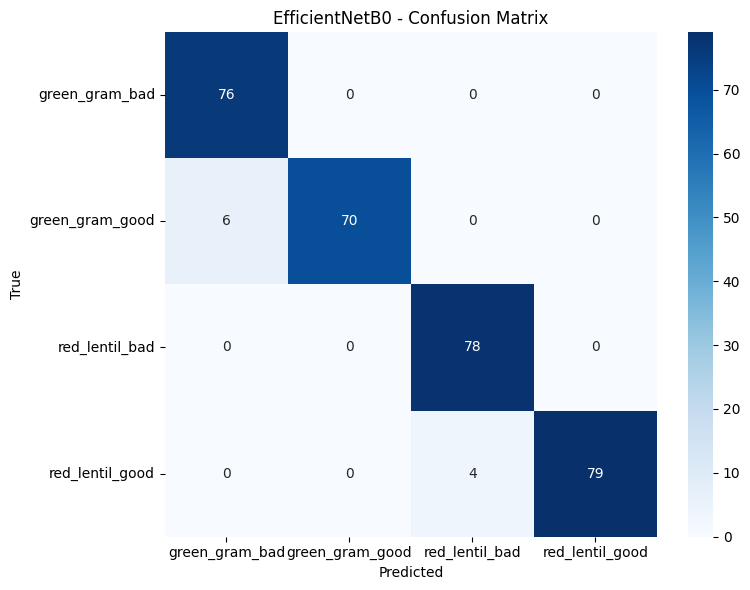

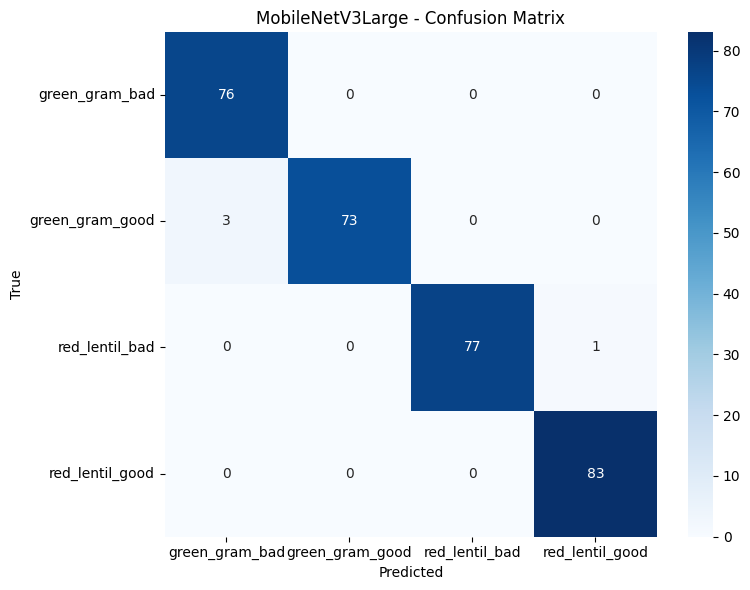

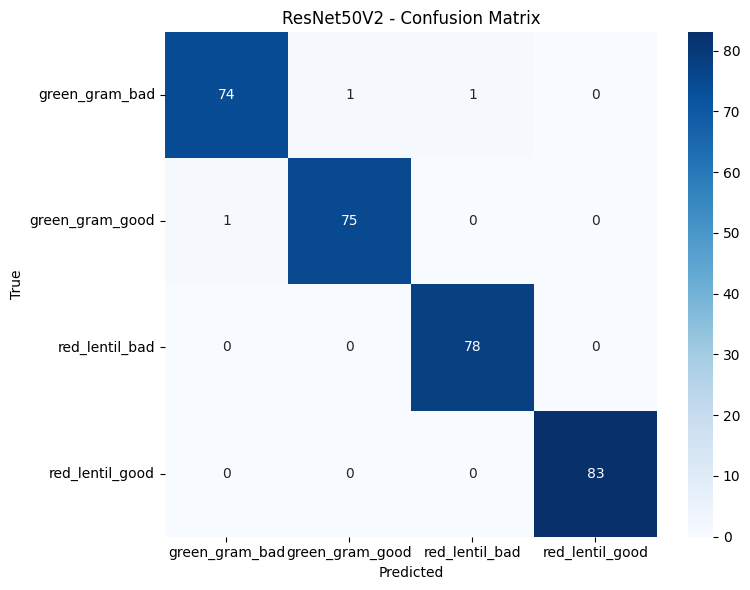

In [22]:
import seaborn as sns

def plot_cm(cm, title, class_names):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(res_e['cm'], 'EfficientNetB0 - Confusion Matrix', class_names)
plot_cm(res_m['cm'], 'MobileNetV3Large - Confusion Matrix', class_names)
plot_cm(res_r['cm'], 'ResNet50V2 - Confusion Matrix', class_names)

###Compare models (table)


=== Model Comparison ===
           Model  Accuracy
      ResNet50V2  0.990415
MobileNetV3Large  0.987220
  EfficientNetB0  0.968051


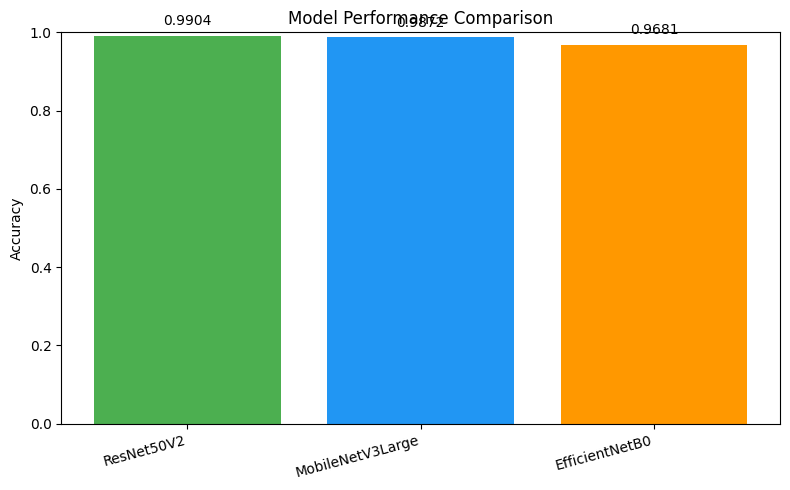

In [23]:
import pandas as pd

compare = pd.DataFrame([
    {'Model': 'EfficientNetB0', 'Accuracy': res_e['acc']},
    {'Model': 'MobileNetV3Large', 'Accuracy': res_m['acc']},
    {'Model': 'ResNet50V2', 'Accuracy': res_r['acc']},
])

compare = compare.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\n=== Model Comparison ===")
print(compare.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(8, 5))
plt.bar(compare['Model'], compare['Accuracy'], color=['#4CAF50', '#2196F3', '#FF9800'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim([0, 1])
plt.xticks(rotation=15, ha='right')
for i, v in enumerate(compare['Accuracy']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

###Plot training history

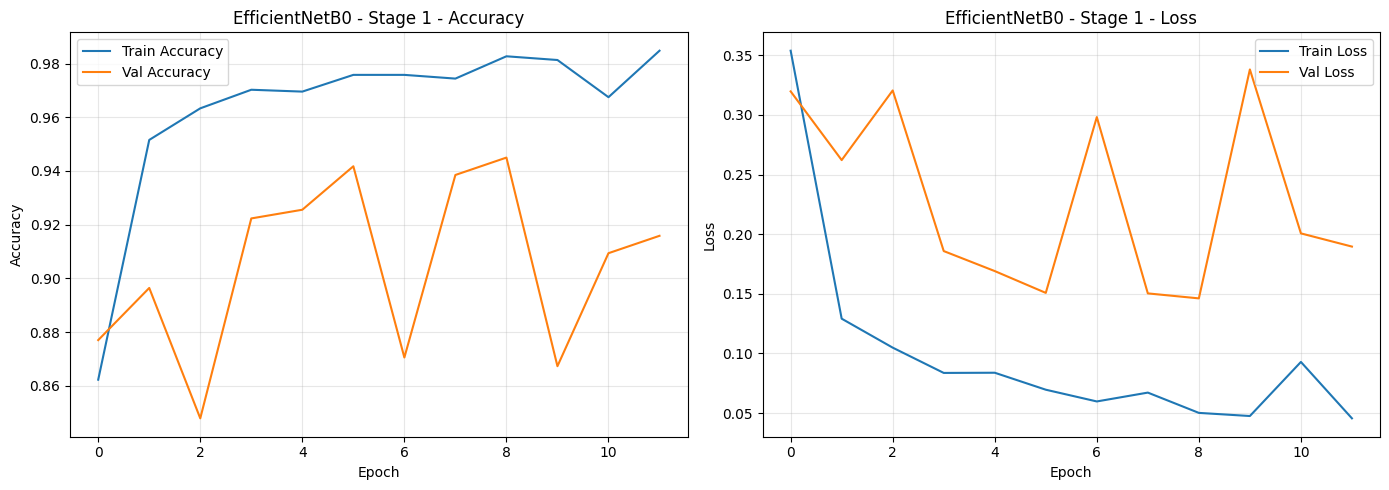

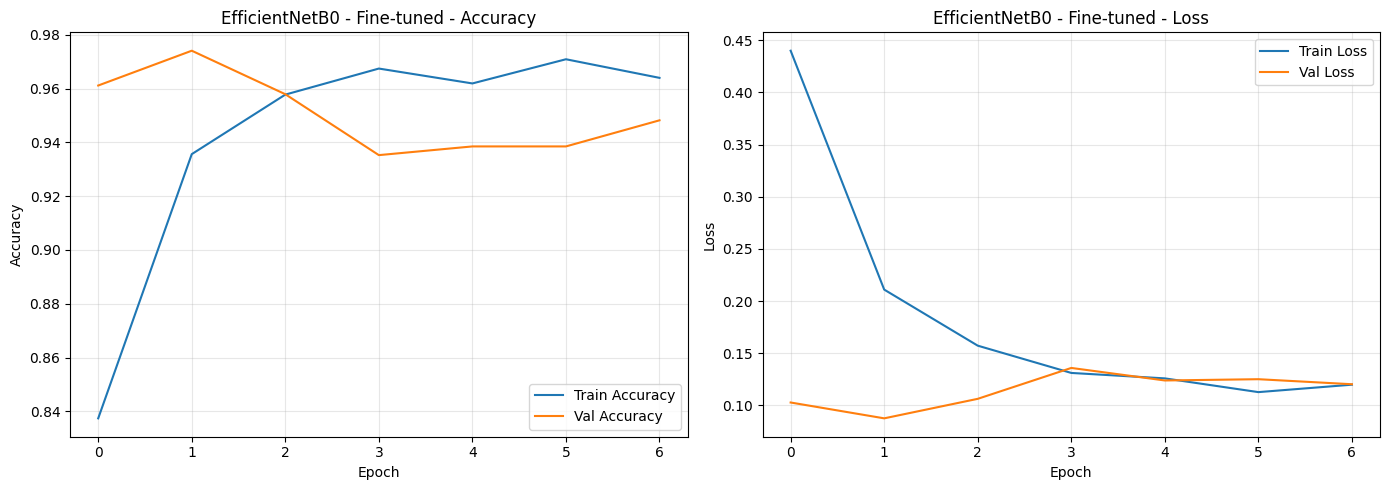

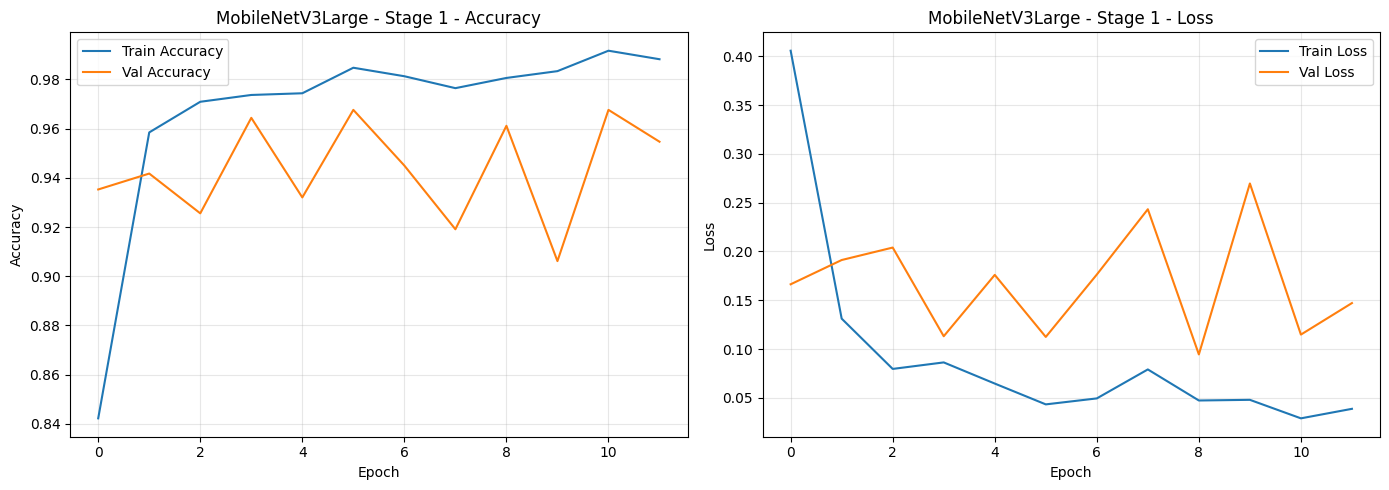

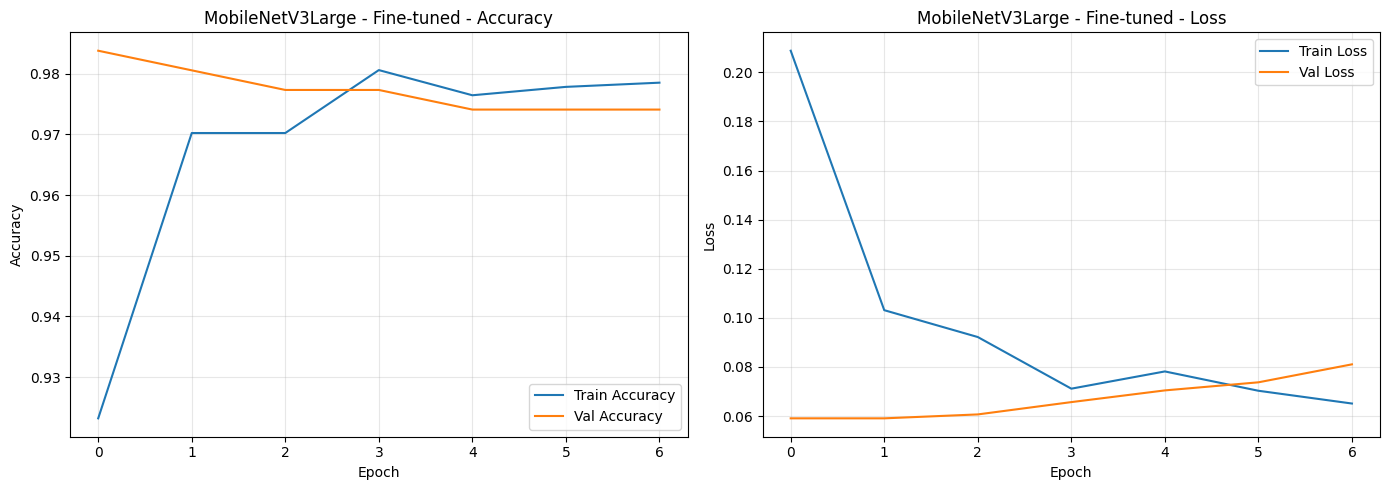

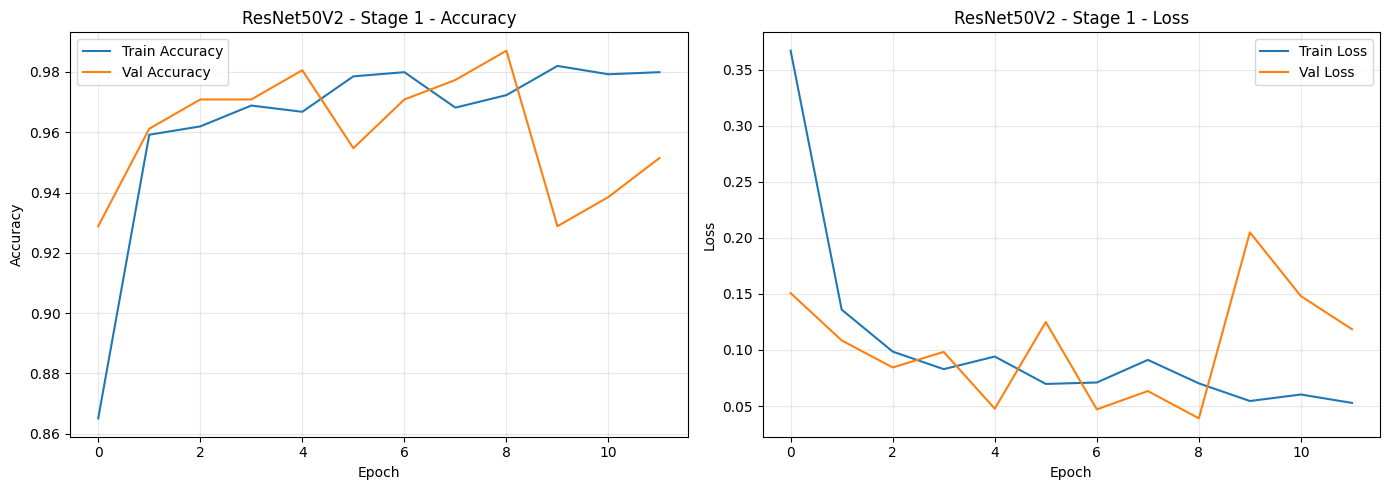

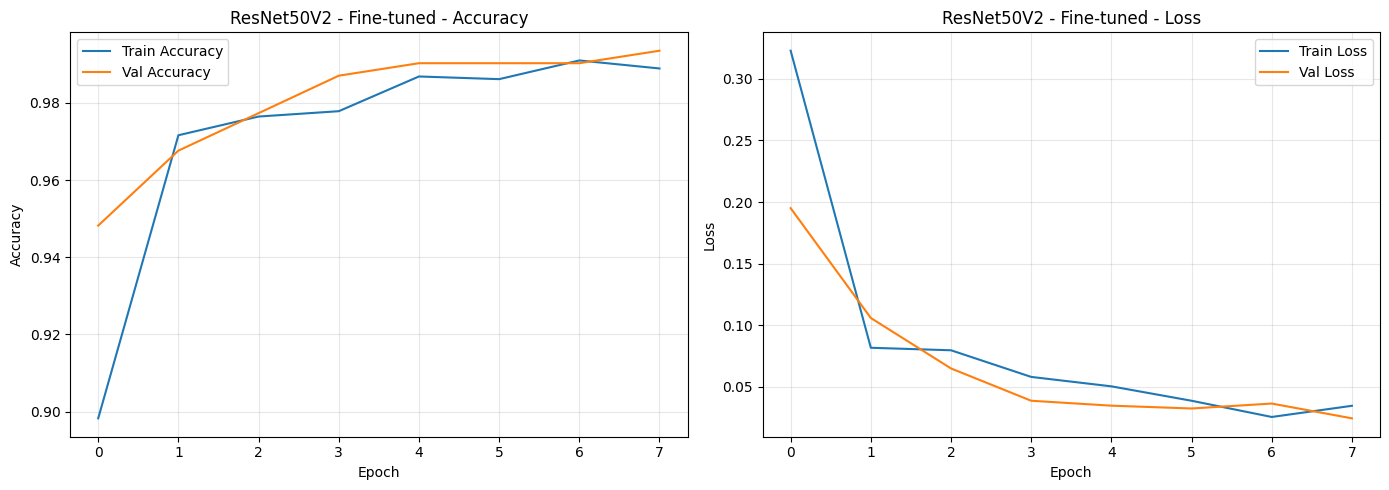

In [24]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_history(history_e, 'EfficientNetB0 - Stage 1')
plot_history(history_e_ft, 'EfficientNetB0 - Fine-tuned')
plot_history(history_m, 'MobileNetV3Large - Stage 1')
plot_history(history_m_ft, 'MobileNetV3Large - Fine-tuned')
plot_history(history_r, 'ResNet50V2 - Stage 1')
plot_history(history_r_ft, 'ResNet50V2 - Fine-tuned')

###Save the best model

In [25]:
# Determine best model
best_idx = compare['Accuracy'].idxmax()
best_model_name = compare.loc[best_idx, 'Model']
best_acc = compare.loc[best_idx, 'Accuracy']

print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")

# Save best model
if best_model_name == 'EfficientNetB0':
    best_model = model_e
elif best_model_name == 'MobileNetV3Large':
    best_model = model_m
else:
    best_model = model_r

best_model.save('best_seed_classifier.h5')
print("Best model saved as 'best_seed_classifier.h5'")



Best Model: ResNet50V2 with Accuracy: 0.9904
Best model saved as 'best_seed_classifier.h5'


###Test prediction on sample images


Sample predictions from ResNet50V2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


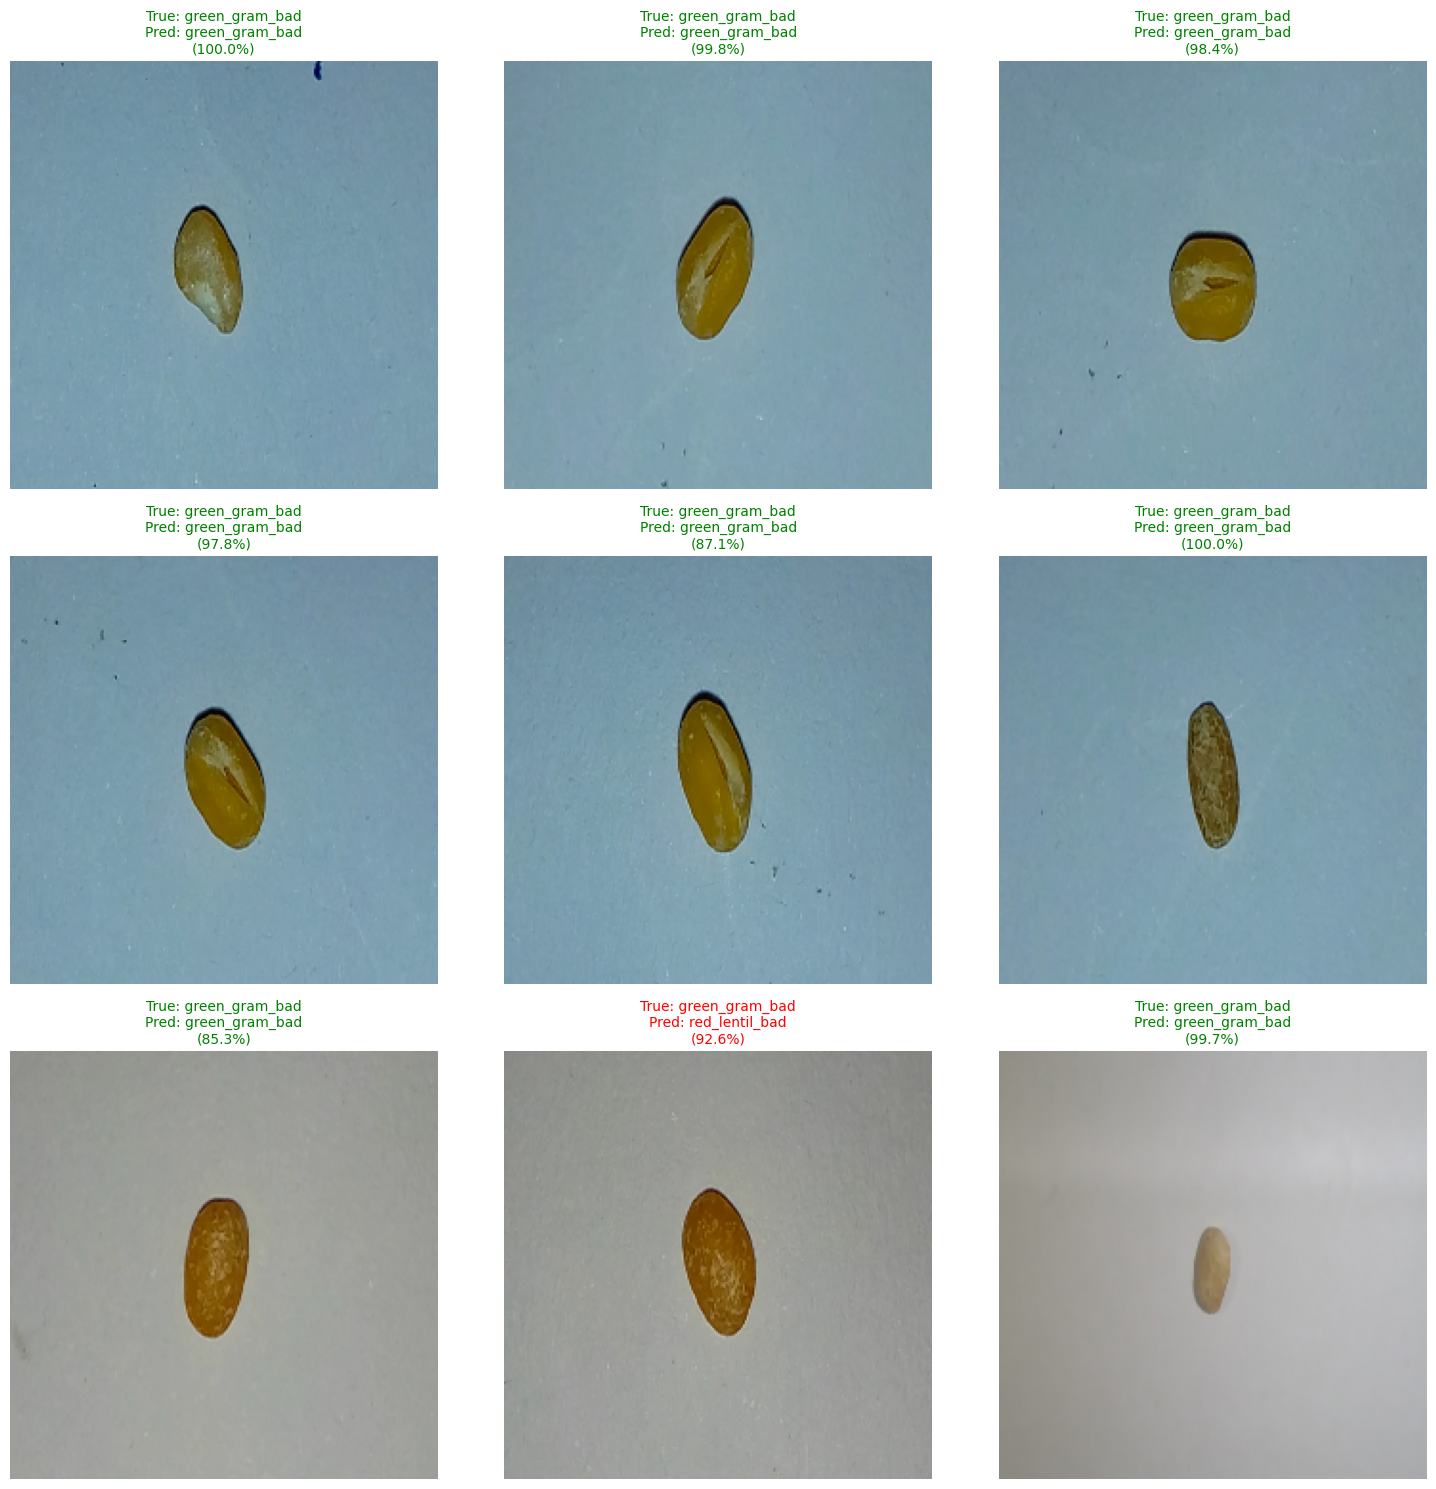

In [26]:
def predict_sample_images(model, test_ds, class_names, num_samples=9):
    """
    Display sample predictions from test set
    """
    # Get one batch
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)

        # Plot
        plt.figure(figsize=(15, 15))
        for i in range(min(num_samples, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_classes[i]]
            confidence = predictions[i][pred_classes[i]] * 100

            color = 'green' if pred_classes[i] == labels[i] else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                     color=color, fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Show predictions from best model
print(f"\nSample predictions from {best_model_name}:")
predict_sample_images(best_model, test_ds, class_names)